# Recommabder System With Book_Crossing Data with Surprise Framework
This notebook focuses on collabrative filtering approach to build a recommendation system for books using Book_Crossing Data

Data Source: http://www2.informatik.uni-freiburg.de/~cziegler/BX/



## Ingest

In [1]:
! pip install -q surprise

In [1]:
import pandas as pd
import numpy as np

In [2]:
user = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

df = pd.merge(user, rating, on='userID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)
df["bookRating"]=df["bookRating"].astype("int")
df["userID"]=df["userID"].astype("int")

df.head()


userID        ISBN  bookRating
0       2  0195153448           0
1       7   034542252           0
2       8  0002005018           5
3       8  0060973129           0
4       8  0374157065           0

## EDA

In [3]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import seaborn as sns 
import matplotlib.pyplot as plt

Text(0.5,1,'Distribution of Book Ratings')

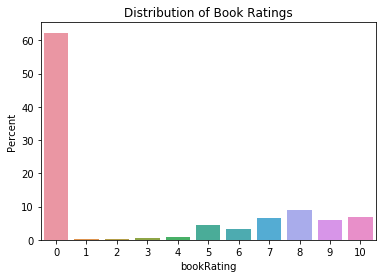

In [4]:
ax = sns.barplot(x="bookRating", y="bookRating", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")
ax.set_title("Distribution of Book Ratings")


we can see the over 60% of book has 0 ratings. Readers are reluctant to rate books when they are bad so we can assume 0 rating books are generally really bad. 

### Ratings Distribution By Book

In [17]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

ISBN  bookRating
247408  0971880107        2502
47371   0316666343        1295
83359   0385504209         883
9637    0060928336         732
41007   0312195516         723
101670  044023722X         647
166705  0679781587         639
28153   0142001740         615
166434  067976402X         614
153620  0671027360         586

In [10]:
data = df.groupby('ISBN')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 25,
                                  size = 1))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 100)',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

most books recieve 5 ratings, most rated books received 2502 ratings

### Ratings Distribution By User

In [19]:
# Number of ratings per user
data = df.groupby('userID')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 1))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [18]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

userID  bookRating
4213     11676       13602
74815   198711        7550
58113   153662        6109
37356    98391        5891
13576    35859        5850
80185   212898        4785
105111  278418        4533
28884    76352        3367
42037   110973        3100
88584   235105        3067

Most of the users in the data gave less than 5 ratings. The most engaged user gave 13602 ratings

### In order to save memory, we filter out least rated users and books 

In [21]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print(f'The original data frame shape {df.shape}')
print(f'The new data frame shape {df_new.shape}')

The original data frame shape (1149780, 3)
The new data frame shape (140516, 3)


## Model - Surprise!!

In [22]:
from surprise import Reader, Dataset, BaselineOnly, evaluate, accuracy
from surprise.model_selection import cross_validate, train_test_split


### Research on different models in surprise

#### Basic algorithms
NormalPredictor

NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

#### BaselineOnly

BaselineOnly algorithm predicts the baseline estimate for given user and item.
k-NN algorithms

#### KNNBasic

KNNBasic is a basic collaborative filtering algorithm.

#### KNNWithMeans

KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.
KNNWithZScore

KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

#### KNNBaseline

KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.
Matrix Factorization-based algorithms

#### SVD

SVD algorithm is equivalent to Probabilistic Matrix Factorization

#### SVDpp

The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.

#### NMF

NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

#### Slope One
SlopeOne is a straightforward implementation of the SlopeOne algorithm.

#### Co-clustering
Coclustering is a collaborative filtering algorithm based on co-clustering.
We use “rmse” as our accuracy metric for the predictions.

![alt text](https://cdn-images-1.medium.com/max/800/1*FXsZ2qM4fUA_82-p4XGaiw.png)

In [23]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

#### train and predict with BaselineOnly and use Alternating Least Squares (ALS)

In [24]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([3.39090858, 3.36410339, 3.36982578]),
 'fit_time': (0.1591629981994629, 0.18353629112243652, 0.1857748031616211),
 'test_time': (0.35863709449768066, 0.25522685050964355, 0.2964041233062744)}

In [25]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.3648


3.364834358857696

In [26]:

def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
result = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
result['Iu'] = result.uid.apply(get_Iu)
result['Ui'] = result.iid.apply(get_Ui)
result['err'] = abs(result.est - result.rui)
best_predictions = result.sort_values(by='err')[:10]
worst_predictions = result.sort_values(by='err')[-10:]



In [27]:
result.head()

uid         iid  rui       est                    details   Iu   Ui  \
0  238864  0743418174  0.0  3.477406  {'was_impossible': False}   33  184   
1   25981  0312966970  0.0  4.020387  {'was_impossible': False}   92  112   
2   55492  034538475X  0.0  1.252232  {'was_impossible': False}  380   95   
3  177458  0451188454  0.0  1.605903  {'was_impossible': False}  100   50   
4  132083  1573222267  8.0  1.410191  {'was_impossible': False}   35   15   

        err  
0  3.477406  
1  4.020387  
2  1.252232  
3  1.605903  
4  6.589809

In [28]:
best_predictions

uid         iid  rui  est                    details   Iu   Ui  err
24823  256167  0345425308  0.0  0.0  {'was_impossible': False}   62   31  0.0
31169  170518  0061092045  0.0  0.0  {'was_impossible': False}  158   33  0.0
27222  115120  0440241073  0.0  0.0  {'was_impossible': False}  243  146  0.0
31181  145451  0821770209  0.0  0.0  {'was_impossible': False}  151   35  0.0
27217  238120  0743418190  0.0  0.0  {'was_impossible': False}  338   27  0.0
18909   59971  0061099694  0.0  0.0  {'was_impossible': False}   49   32  0.0
18921  245963  042510687X  0.0  0.0  {'was_impossible': False}  146   41  0.0
3840   269566  0743411250  0.0  0.0  {'was_impossible': False}  272   47  0.0
9472   172030  0345386108  0.0  0.0  {'was_impossible': False}  108   58  0.0
31190   32195  0553572210  0.0  0.0  {'was_impossible': False}  112   40  0.0

In [29]:
worst_predictions

uid         iid   rui       est                    details   Iu  \
25818  224525  0971880107  10.0  0.306624  {'was_impossible': False}   10   
34105   14521  0440222656  10.0  0.276960  {'was_impossible': False}  166   
6455   197775  0515093556  10.0  0.223308  {'was_impossible': False}   76   
9016    14521  0553275976  10.0  0.170756  {'was_impossible': False}  166   
27975  217375  0553569031  10.0  0.157985  {'was_impossible': False}  240   
12545   49109  034540288X  10.0  0.111603  {'was_impossible': False}   98   
34047   26544  0515128600  10.0  0.100542  {'was_impossible': False}  195   
34527  200674  0451160533  10.0  0.000000  {'was_impossible': False}  147   
28518  245963  0425170349  10.0  0.000000  {'was_impossible': False}  146   
7718   161752  1551668912  10.0  0.000000  {'was_impossible': False}   66   

        Ui        err  
25818  624   9.693376  
34105  184   9.723040  
6455    35   9.776692  
9016    93   9.829244  
27975   49   9.842015  
12545  113   9.888397  
34047   34   9.899458  
34527   28  10.000000  
28518   45  10.000000  
7718    37  10.000000

Text(0.5,1,'error distribution <0: over est, >0: under est')

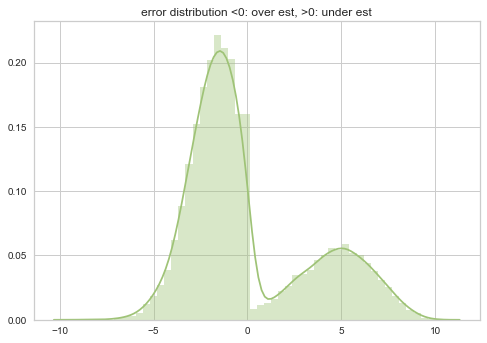

In [36]:
#error, overestimate vs underestimate 
diff = result["rui"]-result["est"]
ax = sns.distplot(diff, color="g")
ax.set_title("error distribution <0: over est, >0: under est")

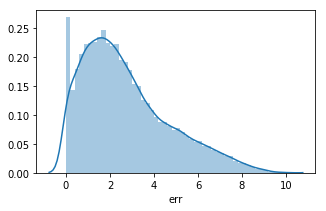

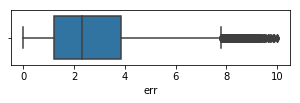

In [30]:
fig, ax = plt.subplots(figsize=(5,3))

ax=sns.distplot(result["err"])

fig, ax = plt.subplots(figsize=(5,1))

ax=sns.boxplot(result["err"])

## Conclusion

The baseline mode predicts the book rating fairly accurately given accuracy score of 3.37 and right skewed distribution on err